In [155]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
df_DH_train = pd.read_csv('C:/Users/dohan/Desktop/newww/house-prj/DH_train.csv')
df_team_train = pd.read_csv('C:/Users/dohan/Desktop/newww/house-prj/new_train.csv')

In [156]:
df_DH_train['log_SalePrice'] = np.log1p(df_DH_train['SalePrice'])
df_team_train['log_SalePrice'] = np.log1p(df_team_train['SalePrice'])

In [157]:
def LinearReg(data, target, *features):
    y = np.array(data[target])[np.newaxis].T

    X = np.ones([len(data), 1])
    for feature in features:
        X = np.hstack((X, np.array(data[feature])[np.newaxis].T))

    w, resid, rank, s = np.linalg.lstsq(X, y)

    print("w{} : {}".format("Const", w[0]), end = " ")
    
    for i in range(len(w)-1):
        print("w{} : {}".format(features[i], w[i+1]), end = " ")
        
    RMSE = np.sqrt(resid / len(data))
    print("\n RMSE : {}".format(RMSE))
    print("rank : {}".format(rank))
    
    print("cross validation : {}".format(crossValidation(10, data, target, *features)))
    
    # draw chart
    # 예측치와 실제치과의 관계표시(scatter plot)
    predict = np.dot(X, w)
    
    plt.scatter(y, predict)
    plt.xlabel("target value")
    plt.ylabel("predict value")
    plt.xlim(data[target].min(), data[target].max())
    plt.show()

In [158]:
def crossValidation(num, data, target, *features):
    rmses = []
    
    # 데이터프래임에서 target과 features 추출 
    data = data[[*features, target]]
    
    # 데이터프래임 num 갯수로 분할
    remain = data.shape[0] % num
    data_set = np.split(data.values[:data.shape[0]-remain], num)
    data_set[num-1] = np.vstack([data_set[num-1], data.values[data.shape[0]-remain:]])
    
    # 각 fold로 계산하여 rmse를 계산
    for i in range(num):
        
        # test_set과 train_set 제작
        test_set = data_set[i] # test set 

        if (i==0): # train set
            train_set = data_set[1:]
        elif (i==9):
            train_set = data_set[:num-1]
        else:
            train_set = data_set[:i]
            train_set += data_set[i+1:]
        train_set = np.concatenate(train_set)
        
        # train_set으로 linear regression 모델 훈련
        y = train_set[:, -1][np.newaxis].T
        X = np.ones([train_set.shape[0], 1])
        X = np.hstack((X, train_set[:, :train_set.shape[1]-1]))
        
        w, resid, rank, s = np.linalg.lstsq(X, y)
        
        # test_set으로 predict 계산 및 target 생성
        test_X = np.hstack((np.ones([test_set.shape[0], 1]), test_set[:, :test_set.shape[1]-1]))
        predict_test = np.dot(test_X, w).T[0]
        target_test = test_set[:,-1]
        
        # rmse 계산
        rss = np.square(predict_test - target_test).sum()
        rmses.append(np.sqrt(rss / test_X.shape[0]))    
    
    # rmse_avr 계산
    rmse_avr = sum(rmses) / num
    
    # print rmse
#     for idx, rmse in enumerate(rmses):
#         print("test{} : {:1.2f}".format(idx, rmse), end = " ")
    
#     print("\n average of rmse : {:1.2f}".format(rmse_avr))
    return rmse_avr

In [159]:
def LinearRegSM(data, target, *features):
    y = np.array(data[target])[np.newaxis].T
    
    #data[*features]
    dfX = sm.add_constant(data[[*features]])
    dfy = data[target]
    
    model = sm.OLS(dfy, dfX)
    result = model.fit()
    print(result.summary())
    return result

wConst : [ 4.22744141] wOverallQual : [ 0.10475934] wGrLivArea : [ 0.00015029] wGarageArea : [ 0.00024729] w1stFlrSF : [ 0.00015578] wYearBuilt : [ 0.00128933] wYearRemodAdd : [ 0.0019818] wTotalBath : [ 0.0644256] 
 RMSE : [ 0.16745915]
rank : 8
cross validation : 0.1674450187770461


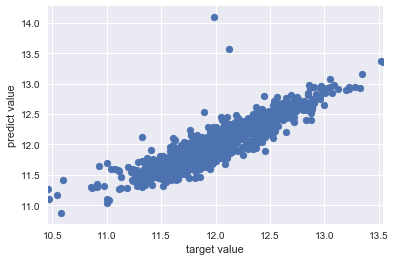

In [160]:
# TotalBath -> 0.167
LinearReg(df_DH_train, "log_SalePrice",
              'OverallQual',
              'GrLivArea',
              'GarageArea',
              '1stFlrSF',
              'YearBuilt',
              'YearRemodAdd', "TotalBath")

wConst : [ 3.5394191] wOverallQual : [ 0.10538452] wGrLivArea : [ 0.00019143] wGarageArea : [ 0.00023955] w1stFlrSF : [ 0.00012951] wYearBuilt : [ 0.00158805] wYearRemodAdd : [ 0.00204656] wFullBath : [ 0.02515359] wHalfBath : [ 0.04301893] wBsmtFullBath : [ 0.08327167] wBsmtHalfBath : [ 0.06961431] 
 RMSE : [ 0.16647241]
rank : 11
cross validation : 0.16680844168450598


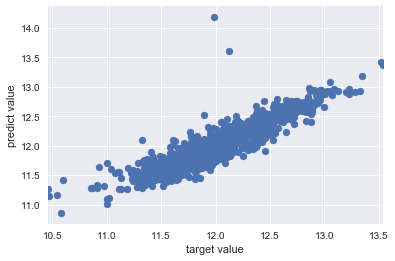

In [161]:
# 0.166

LinearReg(df_DH_train, "log_SalePrice",
              'OverallQual',
              'GrLivArea',
              'GarageArea',
              '1stFlrSF',
              'YearBuilt',
              'YearRemodAdd',
              'FullBath',
              'HalfBath',
              'BsmtFullBath',
              'BsmtHalfBath')

wConst : [ 2.10664675] wOverallQual : [ 0.10083325] wGrLivArea : [ 0.00021661] wGarageArea : [ 0.00024811] w1stFlrSF : [ 0.0001271] wYearBuilt : [ 0.00227253] wYearRemodAdd : [ 0.00212385] wPorchArea : [ 0.00015728] 
 RMSE : [ 0.17135615]
rank : 8
cross validation : 0.17133595719930417


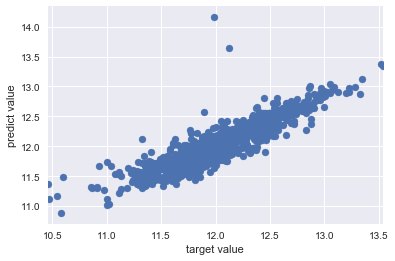

In [162]:
# PorchArea -> 0.171

LinearReg(df_DH_train,"log_SalePrice",
              'OverallQual',
              'GrLivArea',
              'GarageArea',
              '1stFlrSF',
              'YearBuilt',
              'YearRemodAdd',
              'PorchArea')

wConst : [ 2.02219342] wOverallQual : [ 0.10122713] wGrLivArea : [ 0.00022057] wGarageArea : [ 0.00024934] w1stFlrSF : [ 0.00012353] wYearBuilt : [ 0.00222126] wYearRemodAdd : [ 0.00221772] wOpenPorchSF : [ -1.45576378e-05] wEnclosedPorch : [  3.58006995e-05] w3SsnPorch : [ 0.00025443] wScreenPorch : [ 0.00047039] 
 RMSE : [ 0.1699959]
rank : 11
cross validation : 0.17074735826277118


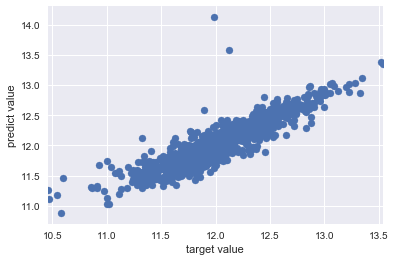

In [163]:
# 0.170

LinearReg(df_DH_train, "log_SalePrice",
                  'OverallQual',
                  'GrLivArea',
                  'GarageArea',
                  '1stFlrSF',
                  'YearBuilt',
                  'YearRemodAdd',
                  "OpenPorchSF", 
                  "EnclosedPorch",
                  "3SsnPorch",
                  "ScreenPorch",
                    )